In [1]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import c2qa
import numpy as np
import qiskit

# Simulation of the Jaynes-Cummings Hamiltonian in the dispersive coupling regime

This tutorial demonstrates simulation of the Jaynes-Cummings Hamiltonian in the dispersive coupling regime, using Bosonic Qiskit. The Jaynes-Cummings Hamiltonian describes the interaction between an oscillator and a two-level system (TLS), the basis for both cavity and circuit QED. In the limit where the rate of interaction between the oscillator and TLS is much less than their detuning (the so-called dispersive coupling regime), the Jaynes-Cummings Hamiltonian can be written as </br>

$H=\omega_R a^\dagger a + \frac{\omega_Q}{2}\sigma^z + \frac{\chi}{2}\sigma^z a^\dagger a$
</br></br>
Because all terms commute, the task of simulating this Hamiltonian is reduced to implementing $U_R=e^{-\omega_R a^\dagger a t}$, $U_Q=e^{-\omega_Q \sigma^z t/2}$ and $U_\chi=e^{-\chi \sigma^z a^\dagger a t/2}$ individually.

In [2]:
# Define Hamiltonian parameters
omega_R = 2
omega_Q = 5
chi = 0.1

### Create unitary gate for time evolution

For the time evolution, we will create a parameterized gate $U_{JC}(t)$, where $t$ is the amount of time we wish to evolve the system. Let's first initialize this circuit, using $3$ qubits for the qumode such that the cutoff is $2^3 = 8$.

In [3]:
from qiskit.circuit import Parameter
# Set number of qubits per qumode
num_qubits_per_qumode = 3

# Define parameter dt
dt = Parameter('dt')

# Create new circuit
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = qiskit.QuantumRegister(1)
U_JC = c2qa.CVCircuit(qmr,qbr)

Now we can implement the three unitaries $U_R(dt)$, $U_Q(dt)$ and $U_\chi(dt)$ which correspond to a phase space rotation, a qubit rotation, and a controlled phase space rotation, respectively.

In [4]:
# Append U_R
U_JC.cv_r(-omega_R*dt,qmr[0])

# Append U_Q
U_JC.rz(omega_Q*dt,qbr[0])

# Append U_\chi -- KS: this needs to be updated to reflect naming conventions in manuscript
U_JC.cv_c_r(-chi*dt/2,qmr[0],qbr[0])

# Compile this circuit into a single parameterized gate
U_JC = U_JC.to_gate(label='U_JC')

AttributeError: 'CVCircuit' object has no attribute 'cv_qdcr'

### Simulate time evolution under the Jaynes-Cummings Hamiltonian in the dispersive regime

Let's first initialize our circuit and prepare the qubit in the $|+\rangle$ state, and the cavity in the vacuum state $|0\rangle$.

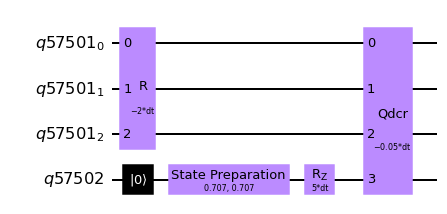

In [ ]:
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = qiskit.QuantumRegister(1)

# Instantiate the circuit and initialize the qubit to the '+' state.
circuit = c2qa.CVCircuit(qmr,qbr)
circuit.initialize([1/np.sqrt(2), 1/np.sqrt(2)], qbr)

# Append the time evolution unitary
circuit.append(U_JC,qmr[0] + [qbr[0]]);

# Draw the circuit
circuit.decompose().draw(output='mpl')

Now time evolve the state for different intervals $dt$ and compute $\langle \sigma^x \rangle$ and $\langle \sigma^z \rangle$ for the qubit. We first must construct the Pauli operators $\sigma^x$ and $\sigma^z$ over the composite Hilbert space $\mathcal{H}_{\textrm{qumode}}\otimes\mathcal{H}_{\textrm{qubit}}$. First, we need to retrieve the identity operator over the qumode. As its dimensionality is dependent upon the cutoff, the easiest way to do this is to use

In [ ]:
I_qumode = circuit.ops.eye.toarray()

Next, we can write the $\sigma^x$ and $\sigma^z$ operators, and take their tensor product with the identity (while minding the appropriate ordering):

In [ ]:
sigmax = np.kron(np.array([[0, 1], [1, 0]]), I_qumode)
sigmaz = np.kron(np.array([[1, 0], [0, -1]]), I_qumode)

In [ ]:
# First construct operator sigma^x. First, we need to retrieve the identity operator over the qumode. As its dimensionality is
# dependent upon the cutoff, the easiest way to do this is to use

tarray = np.linspace(0,3*2*np.pi/omega_Q,100)
sigma_x_expectation = []
sigma_z_expectation = []
for tau in tarray:
    state, result = c2qa.util.simulate(circuit.bind_parameters({dt : tau}))
    sigma_x_expectation.append(state.expectation_value(sigmax).real)
    sigma_z_expectation.append(state.expectation_value(sigmaz).real)

/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Plot $\langle\sigma^x\rangle$ and $\langle\sigma^z\rangle$ as a function of time.

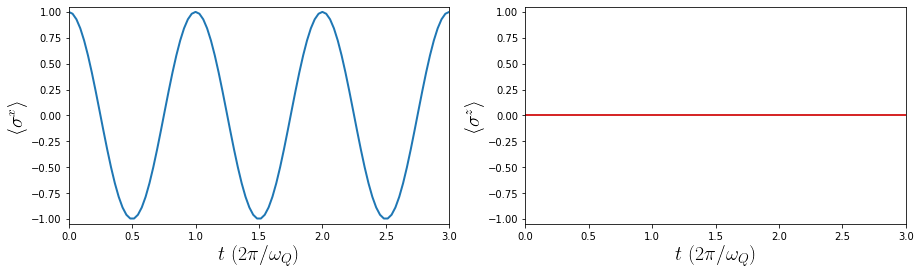

In [ ]:
import matplotlib.pyplot as plt

fontsize = 20

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(tarray/(2*np.pi/omega_Q),sigma_x_expectation,linewidth=2)
plt.ylabel(r'$\langle\sigma^x\rangle$',fontsize=fontsize,usetex=True);
plt.xlabel(r'$t$ $(2\pi/\omega_Q)$',fontsize=fontsize,usetex=True);
plt.xlim([0,3]);
plt.ylim([-1.05,1.05]);

plt.subplot(1,2,2)
plt.plot(tarray/(2*np.pi/omega_Q),sigma_z_expectation,linewidth=2,color='tab:red')
plt.ylabel(r'$\langle\sigma^z\rangle$',fontsize=fontsize,usetex=True);
plt.xlabel(r'$t$ $(2\pi/\omega_Q)$',fontsize=fontsize,usetex=True);
plt.xlim([0,3]);
plt.ylim([-1.05,1.05]);

As expected, the qubit oscillates between the $|+\rangle$ and $|-\rangle$ state at a frequency $\omega_Q$. Meanwhile, the expectation value $\langle \sigma^z$ is static as $\sigma^z$ commutes with the Hamiltonian. What happens if we initialize the qumode to a different Fock state? In this case, the term $\chi a^\dagger a \sigma^z/2$ no longer vanishes, and instead contributes a photon-number dependent shift in the qubit frequency. This is most easily seen by repackaging the full Hamiltonian as </br> </br>
$H=\omega_R a^\dagger a + \left(\frac{\omega_Q + \chi a^\dagger a}{2}\right)\sigma^z$
</br></br>
To see this, we repeat the above experiment, but this time initializing the qumode to different Fock states.

Time evolving for Fock state |0>...


/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Time evolving for Fock state |1>...


/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Time evolving for Fock state |2>...


/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Time evolving for Fock state |3>...


/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Time evolving for Fock state |4>...


/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


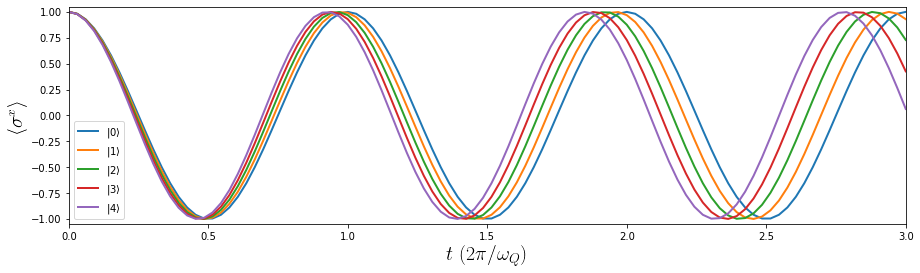

In [ ]:
fockNumberList = [0,1,2,3,4]
tarray = np.linspace(0,3*2*np.pi/omega_Q,100)

plt.figure(figsize=(15,4))
plt.ylabel(r'$\langle\sigma^x\rangle$',fontsize=fontsize,usetex=True);
plt.xlabel(r'$t$ $(2\pi/\omega_Q)$',fontsize=fontsize,usetex=True);
plt.xlim([0,3]);
plt.ylim([-1.05,1.05]);

for fockNumber in fockNumberList:
    print("Time evolving for Fock state |" + str(fockNumber) + '>...')
    qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(1)

    # Instantiate the circuit and initialize the qubit to the '+' state.
    circuit = c2qa.CVCircuit(qmr,qbr)
    circuit.initialize([1/np.sqrt(2), 1/np.sqrt(2)], qbr)

    # Initialize the qumode
    circuit.cv_initialize(fockNumber,qmr[0])

    circuit.append(U_JC,qmr[0] + [qbr[0]]);
    
    sigma_x_expectation = []
    for tau in tarray:
        state, result = c2qa.util.simulate(circuit.bind_parameters({dt : tau}))
        sigma_x_expectation.append(state.expectation_value(sigmax).real)


    plt.plot(tarray/(2*np.pi/omega_Q),sigma_x_expectation,linewidth=2, label = r'$|' + str(fockNumber) + r'\rangle $')

plt.legend()

As expected, the qubit oscillates more rapidly for larger Fock numbers. The dispersive interaction term of the Hamiltonian may also be interpreted as a qubit-dependent shift on the cavity mode frequency, such that </br></br>
$H=\left(\omega_R + \frac{\chi}{2}\sigma^z\right) a^\dagger a + \frac{\omega_Q}{2}\sigma^z$.
</br></br> To visualize this, we can initially prepare the qumode in a coherent state, and animate its wigner function quasiprobability distribution for two different situations: once with the qubit in the $|0\rangle$ state, and another in the $|1\rangle$ state.

In [ ]:
# First construct circuit_qubit0
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = qiskit.QuantumRegister(1)

# Choose alpha for coherent state
alpha = 1

# Choose total animation time
total_time = 3*2*np.pi/omega_R

# Instantiate the circuit and initialize the qubit to the '0' state.
circuit_0 = c2qa.CVCircuit(qmr,qbr)
circuit_0.initialize([1,0], qbr)

# Initialize the qumode in a coherent state using the displacement operator
circuit_0.cv_d(alpha,qmr[0])

# Append time evolution unitary
circuit_0.append(U_JC,qmr[0] + [qbr[0]]);
circuit_0.bind_parameters({dt : total_time})

# Now repeat the above steps for a qubit initialized to the '1' state:
circuit_1 = c2qa.CVCircuit(qmr,qbr)
circuit_1.initialize([0,1], qbr)
circuit_1.cv_d(alpha,qmr[0])
circuit_1.append(U_JC,qmr[0] + [qbr[0]]);
circuit_1 = circuit_1.bind_parameters({dt : total_time})

# Animate wigner function of each circuit
c2qa.util.animate_wigner(circuit_0)

KeyError: 140381775080704